In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
%matplotlib inline

In [ ]:
df = pd.read_csv("data.csv")

In [ ]:
clmns = ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

In [ ]:
def accuracy(m) :
  return (m[0][0]+m[1][1])/(m[0][0]+m[0][1]+m[1][0]+m[1][1])

def sensibility(m) :
  return m[1][1]/(m[1][1]+m[1][0])

def specificity(m) :
  return m[0][0]/(m[0][0]+m[0][1])

def mcc(m) :
  a = m[0][0]*m[1][1] - m[0][1]*m[1][0]
  b = np.sqrt((m[1][1]+m[0][1])*(m[1][1]+m[1][0])*(m[0][0]+m[0][1])*(m[0][0]+m[1][0]))
  return a/b


In [ ]:
def cross_val(X, Y, algorithm, features=-1, cross_validation='cv', k=5, balancing_method='under_sampling') :
  if (features != -1) :
    X_ = pd.DataFrame({feature : df[feature] for feature in features})
    X_ = X_.to_numpy()
    Y_ = df["diagnosis"]
    Y_ = Y_.to_numpy()
  else :
    X_ = X
    Y_ = Y
  if cross_validation == 'cv' :
    splt = KFold(n_splits=k, random_state=1, shuffle=True)
    splits = splt.split(X_)
  elif cross_validation == 'skf' :
    splt = StratifiedKFold(n_splits=k)
    splits = splt.split(X_, Y_)
  model_predictions = []
  actual_labels = []
  scores = []
  if algorithm == 'Gradient_Boosting' :
    model = GradientBoostingClassifier(random_state=42)
  elif algorithm == 'XGradient_Boosting' :
    model = XGBClassifier()
  elif algorithm == 'Logistic_Regression' :
    model = LogisticRegression(random_state=0,  max_iter=100)
  elif algorithm == 'Random_Forest' :
    model = RandomForestClassifier(max_depth=5, random_state=0)
  elif algorithm == 'Gaussian_nb' :
    model = GaussianNB()
  elif algorithm == 'K_Nearest_Neighbors' :
    model = KNeighborsClassifier(n_neighbors=7)
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  fig, ax = plt.subplots()
  n = 0
  for train_index, test_index in splits :
    X_train, Y_train = X_[train_index], Y_[train_index]
    X_test, Y_test = X_[test_index], Y_[test_index]
    if (balancing_method != None and cross_validation == 'cv') :
      if balancing_method == "over_sampling" :
        balancing = RandomOverSampler(random_state=0)
      elif balancing_method == "smote" :
        balancing = SMOTE()
      elif balancing_method == "under_sampling" :
        balancing = RandomUnderSampler(random_state=0)
      X_train, Y_train = balancing.fit_resample(X_train, Y_train)
    model = model.fit(X_train, Y_train)
    #ROC Plot
    viz = RocCurveDisplay.from_estimator(model, X_test, Y_test, name="ROC fold {}".format(n), alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    model_predictions.append(model.predict(X_test))
    actual_labels.append(Y_test)
    scores.append(model.score(X_test, Y_test))
    n += 1
  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.2)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.",)
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic : " + algorithm)
  ax.legend(loc="lower right")
  plt.show()
  performance_metrics = [{} for i in range(k+1)]
  for i in range(k) :
    performance_metrics[i]['confusion_matrix'] = confusion_matrix(model_predictions[i], actual_labels[i])
    conf_mat = performance_metrics[i]['confusion_matrix']
    performance_metrics[i]['accuracy'] = accuracy(conf_mat)
    performance_metrics[i]['sensibility'] = sensibility(conf_mat)
    performance_metrics[i]['specificity'] = specificity(conf_mat)
    performance_metrics[i]['mcc'] = mcc(conf_mat)
  performance_metrics[k]['accuracy_average'] = np.mean([performance_metrics[i]['accuracy'] for i in range(k)])
  #performance_metrics[k]['accuracy_deviation'] = np.std([performance_metrics[i]['accuracy'] for i in range(k)])
  performance_metrics[k]['sensibility_average'] = np.mean([performance_metrics[i]['sensibility'] for i in range(k)])
  #performance_metrics[k]['sensibility_deviation'] = np.std([performance_metrics[i]['sensibility'] for i in range(k)])
  performance_metrics[k]['specificity_average'] = np.mean([performance_metrics[i]['specificity'] for i in range(k)])
  #performance_metrics[k]['specificity_deviation'] = np.std([performance_metrics[i]['specificity'] for i in range(k)])
  performance_metrics[k]['mcc_average'] = np.mean([performance_metrics[i]['mcc'] for i in range(k)])
  #performance_metrics[k]['mcc_deviation'] = np.std([performance_metrics[i]['mcc'] for i in range(k)])
  return performance_metrics

In [ ]:
def cross_val(X, Y, algorithm, features=-1, cross_validation='cv', k=5, balancing_method='under_sampling') :
  if (features != -1) :
    X_ = pd.DataFrame({feature : df[feature] for feature in features})
    X_ = X_.to_numpy()
    Y_ = df["diagnosis"]
    Y_ = Y_.to_numpy()
  else :
    X_ = X
    Y_ = Y
  if cross_validation == 'cv' :
    splt = KFold(n_splits=k, random_state=1, shuffle=True)
    splits = splt.split(X_)
  elif cross_validation == 'skf' :
    splt = StratifiedKFold(n_splits=k)
    splits = splt.split(X_, Y_)
  model_predictions = []
  actual_labels = []
  scores = []
  if algorithm == 'GB' :
    model = GradientBoostingClassifier(random_state=42)
  elif algorithm == 'XGB' :
    model = XGBClassifier()
  elif algorithm == 'LR' :
    model = LogisticRegression(random_state=0,  max_iter=100)
  elif algorithm == 'RF' :
    model = RandomForestClassifier(max_depth=5, random_state=0)
  elif algorithm == 'GNB' :
    model = GaussianNB()
  elif algorithm == 'KNN' :
    model = KNeighborsClassifier(n_neighbors=7)
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  fig, ax = plt.subplots()
  n = 0
  for train_index, test_index in splits :
    X_train, Y_train = X_[train_index], Y_[train_index]
    X_test, Y_test = X_[test_index], Y_[test_index]
    if (balancing_method != None and cross_validation == 'cv') :
      if balancing_method == "over_sampling" :
        balancing = RandomOverSampler(random_state=0)
      elif balancing_method == "smote" :
        balancing = SMOTE()
      elif balancing_method == "under_sampling" :
        balancing = RandomUnderSampler(random_state=0)
      X_train, Y_train = balancing.fit_resample(X_train, Y_train)
    model = model.fit(X_train, Y_train)
    #ROC Plot
    viz = RocCurveDisplay.from_estimator(model, X_test, Y_test, name="ROC fold {}".format(n), alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    model_predictions.append(model.predict(X_test))
    actual_labels.append(Y_test)
    scores.append(model.score(X_test, Y_test))
    n += 1
  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.2)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.",)
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic : " + algorithm)
  ax.legend(loc="lower right")
  plt.show()
  performance_metrics = [{} for i in range(k+1)]
  for i in range(k) :
    performance_metrics[i]['confusion_matrix'] = confusion_matrix(model_predictions[i], actual_labels[i])
    conf_mat = performance_metrics[i]['confusion_matrix']
    performance_metrics[i]['accuracy'] = accuracy(conf_mat)
    performance_metrics[i]['sensibility'] = sensibility(conf_mat)
    performance_metrics[i]['specificity'] = specificity(conf_mat)
    performance_metrics[i]['mcc'] = mcc(conf_mat)
    performance_metrics[i]['auc'] = aucs[i]
  performance_metrics[k]['accuracy_average'] = np.mean([performance_metrics[i]['accuracy'] for i in range(k)])
  #performance_metrics[k]['accuracy_deviation'] = np.std([performance_metrics[i]['accuracy'] for i in range(k)])
  performance_metrics[k]['sensibility_average'] = np.mean([performance_metrics[i]['sensibility'] for i in range(k)])
  #performance_metrics[k]['sensibility_deviation'] = np.std([performance_metrics[i]['sensibility'] for i in range(k)])
  performance_metrics[k]['specificity_average'] = np.mean([performance_metrics[i]['specificity'] for i in range(k)])
  #performance_metrics[k]['specificity_deviation'] = np.std([performance_metrics[i]['specificity'] for i in range(k)])
  performance_metrics[k]['mcc_average'] = np.mean([performance_metrics[i]['mcc'] for i in range(k)])
  #performance_metrics[k]['mcc_deviation'] = np.std([performance_metrics[i]['mcc'] for i in range(k)])
  performance_metrics[k]['auc_average'] = np.mean([performance_metrics[i]['auc'] for i in range(k)])
  return performance_metrics

In [ ]:
X = df.copy()
X.drop(['id','diagnosis', 'Unnamed: 32'],axis=1,inplace=True)
X = X.to_numpy()
Y = df["diagnosis"]
Y = Y.to_numpy()

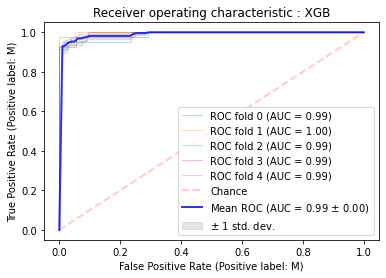

In [ ]:
perf = cross_val(X, Y, "XGB", cross_validation='cv', balancing_method='smote')

In [ ]:
perf[5]

{'accuracy_average': 0.959633597267505,
 'auc_average': 0.9926923828858225,
 'mcc_average': 0.9146863419544164,
 'sensibility_average': 0.9548164837180059,
 'specificity_average': 0.9642492041880775}

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=0)

In [ ]:
def most_k_imp(scrs_, k) :
  scrs = scrs_.copy()
  keys = scrs.keys()
  max_scr_key = 0
  for ke in keys :
    max_scr_key = ke
    break
  top_scrs = []
  for i in range(k) :
    for ke in keys:
      if scrs[ke] > scrs[max_scr_key] :
        max_scr_key = ke
    top_scrs.append(max_scr_key)
    scrs[max_scr_key] = 0
  return top_scrs

def change_keys(scrs) :
  dic = {}
  for k in scrs.keys() :
    try :
      dic[clmns[1 + int(k[1:])]] = scrs[k]
    except :
      return scrs
  return dic

In [ ]:
def xgb_scores(imp_type='weight') :
  scores_av = {key : 0 for key in clmns[2:]}
  splt = StratifiedKFold(n_splits=5).split(X, Y)
  for train_i, test_i in splt :
    X_train, Y_train = X[train_i], Y[train_i]
    X_test, Y_test = X[test_i], Y[test_i]
    model = XGBClassifier()
    model = model.fit(X_train, Y_train)
    scrs = model.get_booster().get_score(importance_type=imp_type)
    for key in scrs.keys() :
      scores_av[clmns[2+int(key[1:])]] += scrs[key]/5 
  return scores_av

def xgb_selector(importance_type='weight', n_features=1) :
  scrs = xgb_scores(imp_type=importance_type)
  selected = most_k_imp(scrs, n_features)
  return selected

def selected_model(importance_type='weight', n_features=1, selected_features=True) :
  features = xgb_selector(importance_type=importance_type, n_features=n_features)
  X = pd.DataFrame({feature : df[feature] for feature in features})
  X = X.to_numpy()
  Y = df["diagnosis"]
  Y = Y.to_numpy()
  print(learn(X, Y, 'XGradient_Boosting', split_method='skf'))


In [ ]:
#perf = selected_model(n_features=10, algo='XGB')
#perf[5]
xgb_scores()

AttributeError: ignored

In [ ]:
max_scrs = xgb_selector(importance_type='weight', n_features=10)
max_scrs

['texture_worst',
 'area_se',
 'area_worst',
 'concave points_worst',
 'texture_mean',
 'concavity_worst',
 'concave points_mean',
 'smoothness_worst',
 'radius_worst',
 'compactness_se']

In [ ]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
learn('Gradient_Boosting', split_method='skf', n_splits=5, j=4)

{'accuracy': 0.9646017699115044,
 'auc': 0.9979879275653923,
 'mcc': 0.9255939267362071,
 'sensibility': 0.9318181818181818,
 'specificity': 0.9855072463768116}